Brillouin Gain Spectrum (BGS) Analysis and Modeling
This notebook performs advanced analysis on Brillouin Gain Spectrum (BGS) data, generates realistic synthetic sequences using segmented statistical modeling, trains a deep learning model to predict peak frequencies and Full Width at Half Maximum (FWHM), and evaluates the model on real data with enhanced visualizations and interpretability.

Project Overview

Data Loading: Read BGS data from text files and visualize distributions.
Advanced Analysis: Segment sequences into pre-Lorentzian, Lorentzian, and post-Lorentzian parts; fit Lorentzian curves; compute detailed statistics including differentials.
Enhanced Synthesis: Generate synthetic data mimicking segmented real statistics with variable noise levels and validation against real distributions.
Preprocessing: Normalize, add adaptive noise, prepare for training with feature scaling.
Modeling: Build and train a multi-output CNN model with advanced regularization and callbacks.
Evaluation: Assess model on real data with metrics, visualizations, SHAP interpretability, and bootstrapped confidence intervals.

The pipeline extracts Brillouin Frequency Shift (BFS) from BGS measurements along optical fibers, enhanced for robustness and scalability.

In [ ]:
try:
    from google.colab import drive
    from google.colab import output
    drive.mount('/content/drive')
    output.enable_custom_widget_manager()
    !jupyter nbextension enable --py widgetsnbextension
except:
    print("Not running in Google Colab, skipping drive mount and widget manager setup.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import os
import random
import pickle
import warnings
from typing import Dict, Any


# Numerical/scientific computing
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                            mean_absolute_error, mean_squared_error, r2_score)

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.regularizers import l2
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                            ModelCheckpoint, TensorBoard)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm
import pickle

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 50)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All dependencies successfully imported!")


SHIFT = 10800
FREQUENCY_START_MHZ = 0
FREQUENCY_END_MHZ = 10934 - SHIFT


BGS_RAW_TXT_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/data/BGS_raw.txt'
MODEL_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/models/best_model.keras'
SCALERS_DIR_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/models/scalers'
LOG_DIR_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/logs'
RESULTS_DIR_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/results'

All dependencies successfully imported!


In [ ]:
def txt_to_numpy_array(file_path: str) -> np.ndarray:
    print(f"Loading BGS data from {file_path}...")

    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Convert text data to numpy array
    data = np.array([list(map(float, line.strip().split(','))) for line in lines])
    data = data[:, ~np.isnan(data).any(axis=0)]  # Remove columns with NaNs

    print(f"Loaded data shape: {data.shape}")
    return data

In [ ]:
real_bgs = txt_to_numpy_array(BGS_RAW_TXT_PATH)
actual_num_freq_points, actual_num_distance_points = real_bgs.shape
print(f"Detected data shape: {actual_num_freq_points} frequency points (rows) and {actual_num_distance_points} distance points (columns).")

distance_axis_m = np.arange(actual_num_distance_points)
frequency_axis_idx = np.arange(actual_num_freq_points)
frequency_axis_mhz = np.linspace(FREQUENCY_START_MHZ, FREQUENCY_END_MHZ, actual_num_freq_points)

Loading BGS data from /content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/data/BGS_raw.txt...
Loaded data shape: (68, 4500)
Detected data shape: 68 frequency points (rows) and 4500 distance points (columns).


In [ ]:
def idx_to_freq(idx):
  return frequency_axis_mhz[idx]

def freq_to_idx(freq):
  idx_array = None
  try:
    idx_array = np.zeros((freq.shape[0]))
    for i in range(freq.shape[0]):
      closest_idx = np.argmin(np.abs(frequency_axis_mhz - freq[i]))
      idx_array[i] = closest_idx
  except:
    print("its not an array of frequencies! make it array!")

  return np.round(idx_array).astype(int)

In [ ]:
def lorentzian(x, A, peak_x, gamma, offset):
    return offset + (A * gamma**2) / ((x - peak_x)**2 + gamma**2)

In [ ]:
def single_lorentzian_freq_gain(x, y):
    try:
        A_guess = np.max(y)
        peak_x_guess = x[x.shape[0]//2]
        gamma_guess = x[-x.shape[0]//4] - x[x.shape[0]//4]
        offset_guess = np.min(y)
        params, _ = curve_fit(lorentzian, x, y,
                            p0=[A_guess, peak_x_guess , gamma_guess, offset_guess],
                            maxfev=5000)

    except RuntimeError:
        print('Lorentzian fit failed - using initial guesses')
        params = [A_guess, peak_x_guess , gamma_guess, offset_guess]

    return {"A": float(params[0]),
            "peak_x": float(params[1]),
            "gamma": np.abs(float(params[2])),
            "offset": float(params[3])}

In [ ]:
def batch_lorentzian_analysis(sequences):
  n_sequences = len(sequences)

  fitted_As = np.zeros((n_sequences))
  fitted_peak_xs = np.zeros((n_sequences))
  fitted_gammas = np.zeros((n_sequences))
  fitted_offsets = np.zeros((n_sequences))

  fitted_lorentzian_curves = []
  fitted_lorentzian_params = []

  for i in range(n_sequences):
    sequence = sequences[i][0]
    freq_range = sequences[i][1]

    res = single_lorentzian_freq_gain(freq_range, sequence)
    A = res['A']
    peak_x = res['peak_x']
    gamma = res['gamma']
    offset = res['offset']

    fitted_lorentzian_curve = lorentzian(freq_range, A, peak_x, gamma, offset)

    fitted_lorentzian_params.append([A, peak_x, gamma, offset])
    fitted_lorentzian_curves.append([fitted_lorentzian_curve, freq_range])

    fitted_As[i] = A
    fitted_peak_xs[i] = peak_x
    fitted_gammas[i] = gamma
    fitted_offsets[i] = offset

  result = {
    "lorentzian_params": fitted_lorentzian_params,
    "lorentzian_curves": fitted_lorentzian_curves,

    "mean_As": np.mean(fitted_As),
    "std_As": np.std(fitted_As),

    "mean_peak_xs": np.mean(fitted_peak_xs),
    "std_peak_xs": np.std(fitted_peak_xs),

    "mean_gammas": np.mean(fitted_gammas),
    "std_gammas": np.std(fitted_gammas),

    "mean_offsets": np.mean(fitted_offsets),
    "std_offsets": np.std(fitted_offsets),
  }

  return result

In [ ]:
def batch_sequences_diff_analysis(sequences):
    n_sequences = len(sequences)

    mean_diffs = np.zeros((n_sequences))
    std_diffs = np.zeros((n_sequences))

    for i in range(n_sequences):
        sequence = sequences[i][0]

        diffs = np.diff(sequence)
        mean_diffs[i] = np.mean(diffs)
        std_diffs[i] = np.std(diffs)


    return {
        "mean_mean_diffs": np.mean(mean_diffs),
        "std_mean_diffs": np.std(mean_diffs),

        "mean_std_diffs": np.mean(std_diffs),
        "std_std_diffs": np.std(std_diffs),
    }

In [ ]:
def data_analyze(data, title="Real Data", plot=True, num_sample_plots=2):
    n_sequences = data.shape[1]

    # Initialize lists to store sequences
    pre_lor_sequences = []
    lorentzian_sequences = []
    post_lor_sequences = []

    min_distances = []

    # Process each sequence
    for i in tqdm(range(n_sequences), desc=f"analyzing {title} sequences"):
        sequence = data[:, i].flatten()
        freq_range = frequency_axis_mhz.flatten()

        peak_idx = np.argmax(sequence)
        pre_peak = sequence[:peak_idx]
        post_peak = sequence[peak_idx:]

        # Find minima for segmentation
        if len(pre_peak) > 3:
            left_minima = argrelextrema(pre_peak, np.less, order=3)[0]
            min1_idx = left_minima[-1] if len(left_minima) > 0 else 0
        else:
            min1_idx = 0

        if len(post_peak) > 3:
            right_minima = argrelextrema(post_peak, np.less, order=3)[0]
            min2_idx = peak_idx + (right_minima[0] if len(right_minima) > 0 else len(post_peak)-1)
        else:
            min2_idx = len(sequence)-1

        min_distances.append(freq_range[peak_idx] - freq_range[min1_idx])
        min_distances.append(freq_range[min2_idx] - freq_range[peak_idx])

        # Segment the sequence
        pre_lor_sequence = sequence[:min1_idx][::-1]
        pre_lor_freqs = freq_range[:min1_idx][::-1]

        lorentzian_sequence = sequence[min1_idx:min2_idx]
        lorentzian_freqs = freq_range[min1_idx:min2_idx]

        post_lor_sequence = sequence[min2_idx:]
        post_lor_freqs = freq_range[min2_idx:]

        pre_lor_sequences.append([pre_lor_sequence, pre_lor_freqs])
        lorentzian_sequences.append([lorentzian_sequence, lorentzian_freqs])
        post_lor_sequences.append([post_lor_sequence, post_lor_freqs])

    # Analyze each segment
    pre_lor_statistics = batch_sequences_diff_analysis(pre_lor_sequences)
    lorentzian_results = batch_lorentzian_analysis(lorentzian_sequences)
    post_lor_statistics = batch_sequences_diff_analysis(post_lor_sequences)

    # Extract peak frequencies and FWHMs
    peak_freqs = []
    fwhms = []
    for curve_params in lorentzian_results["lorentzian_params"]:
        peak_freqs.append(curve_params[1])
        fwhms.append(2*curve_params[2])

    # Plotting section
    if plot:
        # Plot statistics
        plt.figure(figsize=(15, 5))

        # Plot peak frequency distribution
        plt.subplot(1, 3, 1)
        plt.hist(peak_freqs, bins=20, alpha=0.7)
        plt.title("Peak Frequency Distribution")
        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Count")

        # Plot FWHM distribution
        plt.subplot(1, 3, 2)
        plt.hist(fwhms, bins=20, alpha=0.7)
        plt.title("FWHM Distribution")
        plt.xlabel("FWHM (MHz)")
        plt.ylabel("Count")

        plt.suptitle(f"{title} - Statistical Analysis")
        plt.tight_layout()
        plt.show()

        # Sample individual sequence plots
        sample_indices = random.sample(range(n_sequences), min(num_sample_plots, n_sequences))

        for idx in sample_indices:
            plt.figure(figsize=(12, 6))

            # Original sequence
            sequence = data[:, idx].flatten()
            freq_range = frequency_axis_mhz.flatten()

            plt.plot(freq_range, sequence, 'b-', label='Original Data', alpha=0.7)

            # Get the segmentation points
            pre_seq, pre_freq = pre_lor_sequences[idx]
            lor_seq, lor_freq = lorentzian_sequences[idx]
            post_seq, post_freq = post_lor_sequences[idx]

            # Plot segments with different colors
            plt.plot(pre_freq, pre_seq, 'g-', label='Pre-Lorentzian', linewidth=2)
            plt.plot(lor_freq, lor_seq, 'r-', label='Lorentzian', linewidth=2)
            plt.plot(post_freq, post_seq, 'm-', label='Post-Lorentzian', linewidth=2)

            lorentzian_curve = lorentzian_results["lorentzian_curves"][idx]
            plt.plot(lorentzian_curve[1], lorentzian_curve[0], 'k--', label='Fitted Lorentzian', linewidth=2)

            lorentzian_curve_params = lorentzian_results["lorentzian_params"][idx]
            # Mark peak and FWHM
            plt.axvline(lorentzian_curve_params[1], color='k', linestyle=':', alpha=0.5)
            half_max = lorentzian_curve_params[0]/(2*lorentzian_curve_params[2]**2)
            plt.hlines(half_max, lorentzian_curve_params[1]-lorentzian_curve_params[2], lorentzian_curve_params[1]+lorentzian_curve_params[2],
                    colors='k', linestyles=':', linewidth=1.5)

            plt.title(f"{title} - Sequence {idx}\nPeak: {lorentzian_curve_params[1]:.2f} MHz, FWHM: {2*lorentzian_curve_params[2]:.2f} MHz")
            plt.xlabel("Frequency (MHz)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    return {
        "pre_lor_statistics": pre_lor_statistics,
        "lorentzian_analysis_results": lorentzian_results,
        "post_lor_statistics": post_lor_statistics,
        'min_distances_mean': np.mean(min_distances),
        'min_distances_std': np.std(min_distances),
        "peak_frequencies": peak_freqs,
        "fwhms": fwhms,
    }

In [ ]:
def gen_synthetic_data(statistics, n=1000, noise_std=0.01):

    pre_lor_statistics = statistics['pre_lor_statistics']
    lorentzian_statistics = statistics['lorentzian_analysis_results']
    post_lor_statistics = statistics['post_lor_statistics']

    pre_mean_mean_diffs = pre_lor_statistics['mean_mean_diffs']
    pre_std_mean_diffs = pre_lor_statistics['std_mean_diffs']
    pre_mean_std_diffs = pre_lor_statistics['mean_std_diffs']
    pre_std_std_diffs = pre_lor_statistics['std_std_diffs']

    post_mean_mean_diffs = post_lor_statistics['mean_mean_diffs']
    post_std_mean_diffs = post_lor_statistics['std_mean_diffs']
    post_mean_std_diffs = post_lor_statistics['mean_std_diffs']
    post_std_std_diffs = post_lor_statistics['std_std_diffs']

    mean_As = lorentzian_statistics['mean_As']
    std_As = lorentzian_statistics['std_As']
    mean_peak_xs = lorentzian_statistics['mean_peak_xs']
    std_peak_xs = lorentzian_statistics['std_peak_xs']
    mean_gammas = lorentzian_statistics['mean_gammas']
    std_gammas = lorentzian_statistics['std_gammas']
    mean_offsets = lorentzian_statistics['mean_offsets']
    std_offsets = lorentzian_statistics['std_offsets']

    min_distances_mean = statistics['min_distances_mean']
    min_distances_std = statistics['min_distances_std']


    synthetic_sequences = np.zeros((68, n))
    synthetic_sequences_noisy = np.zeros((68, n))
    peak_xs = np.zeros((n))
    fwhms = np.zeros((n))
    for i in range(n):
        freq_range = frequency_axis_mhz.flatten()

        gen_A = np.random.normal(mean_As, std_As)
        gen_peak_x = np.random.normal(mean_peak_xs, std_peak_xs)
        gen_gamma = np.random.normal(mean_gammas, std_gammas)
        gen_offset = np.random.normal(mean_offsets, std_offsets)

        peak_xs[i] = gen_peak_x
        fwhms[i] = 2*gen_gamma


        min1_distance = np.random.normal(min_distances_mean, min_distances_std)
        min2_distance = np.random.normal(min_distances_mean, min_distances_std)
        min1_x = gen_peak_x - min1_distance
        min2_x = gen_peak_x + min2_distance

        min1_idx, min2_idx = freq_to_idx(np.array([min1_x, min2_x]))

        lor_freq_range = freq_range[min1_idx:min2_idx]

        lorentzian_seq = lorentzian(lor_freq_range, gen_A, gen_peak_x, gen_gamma, gen_offset)

        pre_diff_mean = np.random.normal(pre_mean_mean_diffs, pre_std_mean_diffs)
        pre_diff_std = np.abs(np.random.normal(pre_mean_std_diffs, pre_std_std_diffs))
        pre_seq = [lorentzian_seq[0]]
        for j in range(min1_idx-1):
            diff = np.random.normal(pre_diff_mean, pre_diff_std)
            pre_seq.append(pre_seq[-1]+diff)

        pre_seq = pre_seq[::-1]
        synthetic_sequences[:len(pre_seq), i] = pre_seq

        synthetic_sequences[len(pre_seq):len(pre_seq)+len(lorentzian_seq), i] = lorentzian_seq

        post_diff_mean = np.random.normal(post_mean_mean_diffs, post_std_mean_diffs)
        post_diff_std = np.abs(np.random.normal(post_mean_std_diffs, post_std_std_diffs))
        post_seq = [lorentzian_seq[-1]]
        for j in range(68 - min2_idx - 1):
            diff = np.random.normal(post_diff_mean, post_diff_std)
            post_seq.append(post_seq[-1]+diff)

        synthetic_sequences[min2_idx:, i] = post_seq[:68-min2_idx]

        seq = synthetic_sequences[:, i]
        noise_std_high = noise_std*gen_A*2
        noise_std_med = noise_std*gen_A
        noise_std_low = noise_std*gen_A*0.5
        random_noise_std = np.random.choice([noise_std_high, noise_std_med, noise_std_low])

        synthetic_sequences_noisy[:, i] = seq + np.random.normal(0, random_noise_std, size=seq.shape[0])

    return synthetic_sequences, synthetic_sequences_noisy, peak_xs, fwhms


In [ ]:
def visualize_data(sequences, title="Real Data"):
    plots_rows = 3
    plots_columns = 2
    number_of_subplots = plots_rows*plots_columns

    plt.figure(figsize=(20, 16))

    sample_indices = np.random.choice(np.arange(0, sequences.shape[1]), size=number_of_subplots, replace=False)
    selected_sequences = np.zeros((68, number_of_subplots))

    for i in range(len(sample_indices)):
      selected_sequences[:, i] = sequences[:, sample_indices[i]]

    res_analysis = data_analyze(selected_sequences, plot=False)
    peak_freqs = res_analysis['peak_frequencies']
    fwhms = res_analysis['fwhms']
    lorentzian_curves = res_analysis['lorentzian_analysis_results']['lorentzian_curves']


    for i in range(number_of_subplots):

      sequence = selected_sequences[:, i]
      peak_freq = peak_freqs[i]
      fwhm = fwhms[i]
      lorentzian_curve_x = lorentzian_curves[i][1]
      lorentzian_curve_y = lorentzian_curves[i][0]


      fwhm_left_x = peak_freq - fwhm/2
      fwhm_right_x = peak_freq + fwhm/2

      plt.subplot(plots_rows, plots_columns, i+1)
      plt.plot(frequency_axis_mhz, sequence, color='red', label=f'{title}')
      plt.plot(lorentzian_curve_x, lorentzian_curve_y, color='blue', label=f'Lorentzian Fit on {title}')

      plt.axvline(x=peak_freq, color='blue', linestyle='--', label=f'Lorentzian fitted {title} Peaks')
      plt.axvspan(fwhm_left_x, fwhm_right_x, color='green', alpha=0.2, label=f'Lorentzian fitted FWHMs {title}')

      plt.title(f'Sample n:{sample_indices[i]}, Lorentzian fitted FWHM: {fwhm:.5f}')
      plt.xlabel('Frequency (MHz)')
      plt.ylabel('Gain')
      plt.legend()
      plt.grid(True)
      plt.savefig(f'{RESULTS_DIR_PATH}/{title} visualizing sample {sample_indices[1]}.png', dpi=300, bbox_inches='tight')

    plt.show()

analyzing Real Data sequences: 100%|██████████| 6/6 [00:00<00:00, 3551.49it/s]


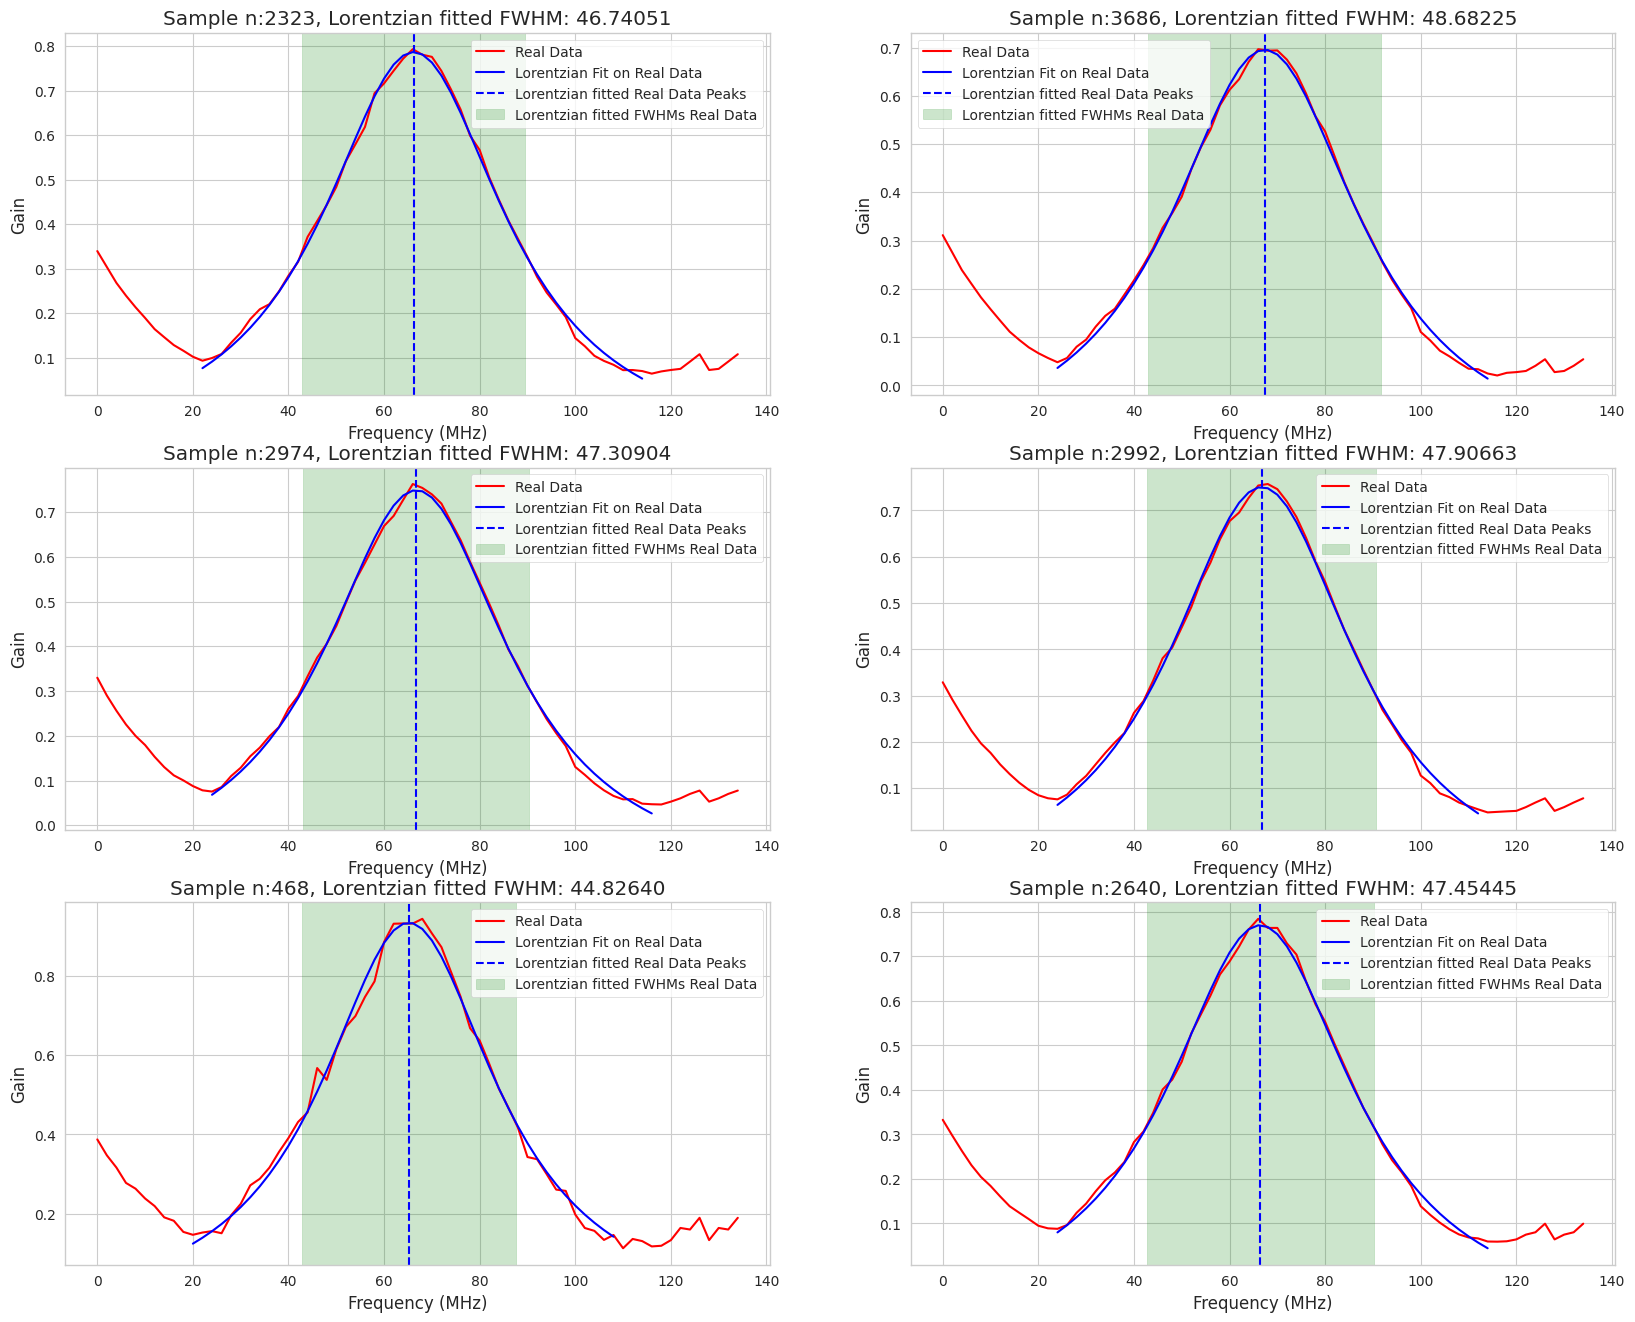

In [ ]:
visualize_data(real_bgs)

In [ ]:
def preprocess_data(sequences, peaks, fwhms, test_size=0.2, random_state=42):

    print("Preprocessing data...")
    n_sequences = sequences.shape[1]
    normalized_sequences = np.zeros_like(sequences)
    for i in tqdm(range(n_sequences), desc="Normalizing sequences"):
        scaler = MinMaxScaler()
        normalized_sequences[:, i] = scaler.fit_transform(
            sequences[:, i].reshape(-1, 1)
        ).flatten()

    X = normalized_sequences.T.reshape((-1, 68, 1))

    # Scale peaks values
    peaks_scaler = StandardScaler()
    normalized_peaks = peaks_scaler.fit_transform(peaks.reshape(-1, 1)).flatten()

    # Scale FWHM values
    fwhms_scaler = StandardScaler()
    normalized_fwhms = fwhms_scaler.fit_transform(fwhms.reshape(-1, 1)).flatten()

    # Train-test split
    X_train, X_test, y_peak_train, y_peak_test, y_fwhm_train, y_fwhm_test = train_test_split(
        X, normalized_peaks, normalized_fwhms, test_size=test_size, random_state=random_state
    )

    y_train = {
        'peak_output': y_peak_train,
        'fwhm_output': y_fwhm_train
    }
    y_test = {
        'peak_output': y_peak_test,
        'fwhm_output': y_fwhm_test
    }


    plt.figure(figsize=(18, 12))
    plot_cols = 2
    plot_rows = 3
    n_samples = plot_cols*plot_rows

    for i in range(n_samples):
        sample_idx = np.random.randint(0, X.shape[0])

        normalized_sequence = X[sample_idx].flatten()
        normalized_peak = normalized_peaks[sample_idx]
        normalized_fwhm = normalized_fwhms[sample_idx]

        peak = peaks_scaler.inverse_transform(normalized_peak.reshape((-1, 1))).flatten()[0]
        fwhm = fwhms_scaler.inverse_transform(normalized_fwhm.reshape((-1, 1))).flatten()[0]


        plt.subplot(plot_rows, plot_cols, i+1)

        plt.plot(frequency_axis_mhz, normalized_sequence, label='Normalized')
        plt.axvline(peak, color='r', linestyle='--', label='Peak')
        plt.title(f'Sample Sequence (Peak: {peak}, FWHM: {fwhm:.2f})')
        plt.legend()

    plt.tight_layout()
    plt.show()

    print("Preprocessing complete. Train shape:", X_train.shape)

    return X_train, X_test, y_train, y_test, peaks_scaler, fwhms_scaler

In [ ]:
def create_model(input_shape=(68, 1)):

    print("Creating dual-output CNN model...")

    # Input layer
    inputs = Input(shape=input_shape, name='input')

    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Peak frequency prediction branch (regression)
    peak_branch = Dense(128, activation='relu')(x)
    peak_branch = Dense(64, activation='relu')(peak_branch)
    peak_branch = BatchNormalization()(peak_branch)
    peak_output = Dense(1, name='peak_output')(peak_branch)

    # FWHM prediction branch (regression)
    fwhm_branch = Dense(128, activation='relu')(x)
    fwhm_branch = Dense(64, activation='relu')(fwhm_branch)
    fwhm_branch = BatchNormalization()(fwhm_branch)
    fwhm_output = Dense(1, name='fwhm_output')(fwhm_branch)

    model = Model(inputs=inputs, outputs=[peak_output, fwhm_output])

    print("Model architecture created successfully!")
    model.summary()

    return model

In [ ]:
def compile_model(model, model_path, log_dir, initial_lr=0.001):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
        loss={
            'peak_output': 'mse',
            'fwhm_output': 'mse'
        },
        loss_weights={
            'peak_output': 0.5,
            'fwhm_output': 0.5
        },
    )

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=32,
            verbose=1,
            restore_best_weights=True,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            update_freq='epoch',
            write_graph=True,
            write_images=True
        )
    ]

    class LRTracker(keras.callbacks.Callback):
        def __init__(self):
            super().__init__()
            self._lrs = []

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
            self._lrs.append(current_lr)
            logs['lr'] = current_lr

    lr_tracker = None
    for cb in callbacks:
        if isinstance(cb, LRTracker):
            lr_tracker = cb
            break

    if lr_tracker is None:
        lr_tracker = LRTracker()
        callbacks.append(lr_tracker)



    return model, callbacks

In [ ]:
def train_and_visualize(model, callbacks, train_X, train_Y, test_X, test_Y,
                       epochs=512, batch_size=1024):

    print(f"Starting training for {epochs} epochs...")

    history = model.fit(
        x=train_X,
        y=train_Y,
        validation_data=(test_X, test_Y),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    plt.figure(figsize=(18, 12))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", 8)

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train', color=palette[0])
    plt.plot(history.history['val_loss'], label='Validation', color=palette[1])
    plt.title('Total Loss (Weighted Sum)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['peak_output_loss'], label='Train', color=palette[2])
    plt.plot(history.history['val_peak_output_loss'], label='Validation', color=palette[3])
    plt.title('Total Loss (Weighted Sum)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['fwhm_output_loss'], label='Train', color=palette[4])
    plt.plot(history.history['val_fwhm_output_loss'], label='Validation', color=palette[5])
    plt.title('Total Loss (Weighted Sum)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 4)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate', color=palette[6])
        plt.title('Learning Rate Schedule')
        plt.ylabel('LR')
        plt.xlabel('Epoch')
        plt.yscale('log')
        plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training complete. Final val loss:", history.history['val_loss'][-1])

    return history

In [ ]:
def full_pipeline(real_bgs, model_path, log_dir, results_dir, scalers_path=None, n_synthetic=300000, test_size=0.2, epochs=128, batch_size=2048):

    print("Analyzing real data statistics...")
    real_data_analysis_res = data_analyze(real_bgs, title="Real Data", plot=False)


    print(f"\nGenerating {n_synthetic} synthetic sequences...")
    synthetic_sequences, synthetic_sequences_noisy, synthetic_peak_xs, synthetic_fwhms = gen_synthetic_data(real_data_analysis_res, n=n_synthetic)


    print("\nPreprocessing data for model training...")
    X_train, X_test, y_train, y_test, peaks_scaler, fwhms_scaler = preprocess_data(
        synthetic_sequences_noisy,
        synthetic_peak_xs,
        synthetic_fwhms,
        test_size=test_size
    )

    if scalers_path:
        with open(f'{scalers_path}/fwhms_scaler.pkl', 'wb') as f:
            pickle.dump(fwhms_scaler, f)
        with open(f'{scalers_path}/peaks_scaler.pkl', 'wb') as f:
            pickle.dump(peaks_scaler, f)

    print("\nCreating dual-output model architecture...")
    model = create_model()
    plot_model(model, to_file=f'{results_dir}/model_plot.png', show_shapes=True, show_layer_names=True)

    print("\nCompiling model with dual-loss configuration...")
    model, callbacks = compile_model(model, model_path=model_path, log_dir=log_dir)

    print(f"\nTraining model for {epochs} epochs...")
    history = train_and_visualize(
        model,
        callbacks,
        X_train,
        y_train,
        X_test,
        y_test,
        epochs=epochs,
        batch_size=batch_size
    )

In [ ]:
def evaluate_prediction_model(model_path: str, bgs_txt_path: str, scalers_path: str) -> Dict[str, Any]:

    print("\n" + "="*60)
    print("Starting Model Evaluation")
    print("="*60)

    try:
        # Load data and model
        real_bgs = txt_to_numpy_array(bgs_txt_path)
        model = keras.models.load_model(model_path)
        print(f"\nSuccessfully loaded model from {model_path}")

        # Load scalers
        with open(f'{scalers_path}/fwhms_scaler.pkl', 'rb') as f:
            fwhms_scaler = pickle.load(f)
        with open(f'{scalers_path}/peaks_scaler.pkl', 'rb') as f:
            peaks_scaler = pickle.load(f)
        print(f"\nSuccessfully loaded scalers from {scalers_path}")

    except Exception as e:
        print(f"Error loading model or data: {e}")
        return None

    # Analyze real data
    real_data_analysis = data_analyze(real_bgs, title="Real Data", plot=False)

    real_peak_freqs = np.array(real_data_analysis['peak_frequencies'])
    real_fwhms = np.array(real_data_analysis['fwhms'])
    n_samples = real_bgs.shape[1]

    # Preprocess data
    normalized_sequences = np.zeros_like(real_bgs)
    for i in range(n_samples):
        scaler = MinMaxScaler()
        normalized_sequences[:, i] = scaler.fit_transform(real_bgs[:, i].reshape(-1, 1)).flatten()
    X = (normalized_sequences.T).reshape((-1, 68, 1))

    # Make predictions
    print("\nMaking predictions...")
    pred_peak_freqs, pred_fwhms = model.predict(X, verbose=1)


    # Inverse transform predictions
    pred_peak_freqs = peaks_scaler.inverse_transform(pred_peak_freqs).flatten()
    pred_fwhms = fwhms_scaler.inverse_transform(pred_fwhms).flatten()

    # Calculate metrics
    metrics = {
        'peak_frequency': {
            'mae': mean_absolute_error(real_peak_freqs, pred_peak_freqs),
            'rmse': np.sqrt(mean_squared_error(real_peak_freqs, pred_peak_freqs)),
            'r2': r2_score(real_peak_freqs, pred_peak_freqs)
        },
        'fwhm': {
            'mae': mean_absolute_error(real_fwhms, pred_fwhms),
            'rmse': np.sqrt(mean_squared_error(real_fwhms, pred_fwhms)),
            'r2': r2_score(real_fwhms, pred_fwhms)
        }
    }

    # Visualization
    plt.figure(figsize=(20, 15))
    sns.set_style("whitegrid")
    plt.suptitle("Model Evaluation Results", y=1.02, fontsize=16)

    # 1. Sample sequences with predictions
    plt.subplot(2, 3, 1)
    sample_idx = np.random.choice(n_samples, size=min(3, n_samples), replace=False)
    for idx in sample_idx:
        plt.plot(frequency_axis_mhz, normalized_sequences[:, idx], alpha=0.7, label=f'Sample {idx}')
        plt.axvline(real_peak_freqs[idx], color='green', linestyle='--', alpha=0.7, label='True Peak' if idx == sample_idx[0] else "")
        plt.axvline(pred_peak_freqs[idx], color='red', linestyle=':', alpha=0.7, label='Predicted Peak' if idx == sample_idx[0] else "")
    plt.title('Sample Sequences with Peak Predictions')
    plt.xlabel('Frequency Index')
    plt.ylabel('Normalized Gain')
    plt.legend()

    # 2. Peak frequency error distribution
    plt.subplot(2, 3, 2)
    peak_errors = pred_peak_freqs - real_peak_freqs
    sns.histplot(peak_errors, bins=30, kde=True, color='royalblue')
    plt.title(f'Peak Frequency Error Distribution\nMAE: {metrics["peak_frequency"]["mae"]:.2f} MHz')
    plt.xlabel('Error (MHz)')

    # 3. FWHM prediction scatter
    plt.subplot(2, 3, 3)
    sns.scatterplot(x=real_fwhms, y=pred_fwhms, alpha=0.5, color='darkorange')
    plt.plot([real_fwhms.min(), real_fwhms.max()],
             [real_fwhms.min(), real_fwhms.max()], 'r--')
    plt.title(f'FWHM Prediction\nMAE: {metrics["fwhm"]["mae"]:.2f}, R²: {metrics["fwhm"]["r2"]:.2f}')
    plt.xlabel('True FWHM (MHz)')
    plt.ylabel('Predicted FWHM (MHz)')

    # 4. FWHM error distribution
    plt.subplot(2, 3, 4)
    fwhm_errors = pred_fwhms - real_fwhms
    sns.histplot(fwhm_errors, bins=30, kde=True, color='forestgreen')
    plt.title('FWHM Error Distribution')
    plt.xlabel('Error (MHz)')

    # 5. Peak frequency vs FWHM relationship
    plt.subplot(2, 3, 5)
    sns.scatterplot(x=real_peak_freqs, y=real_fwhms, color='blue', alpha=0.5, label='True')
    sns.scatterplot(x=pred_peak_freqs, y=pred_fwhms, color='orange', alpha=0.5, label='Predicted')
    plt.title('Peak Frequency vs FWHM Relationship')
    plt.xlabel('Peak Frequency (MHz)')
    plt.ylabel('FWHM (MHz)')
    plt.legend()

    # 6. Error along sequence
    plt.subplot(2, 3, 6)
    plt.plot(peak_errors, label='Peak Frequency Error', alpha=0.7)
    plt.plot(fwhm_errors, label='FWHM Error', alpha=0.7)
    plt.axhline(0, color='k', linestyle='--')
    plt.title('Prediction Errors Along Sequence')
    plt.xlabel('Sample Index')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR_PATH}/summary_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary
    print("\n" + "="*60)
    print("Model Evaluation Summary")
    print("="*60)
    print("Peak Frequency Metrics:")
    print(f"  MAE: {metrics['peak_frequency']['mae']:.2f} MHz")
    print(f"  RMSE: {metrics['peak_frequency']['rmse']:.2f} MHz")
    print(f"  R²: {metrics['peak_frequency']['r2']:.2f}")

    print("\nFWHM Metrics:")
    print(f"  MAE: {metrics['fwhm']['mae']:.2f} MHz")
    print(f"  RMSE: {metrics['fwhm']['rmse']:.2f} MHz")
    print(f"  R²: {metrics['fwhm']['r2']:.2f}")
    print("="*60)



    plt.figure(figsize=(20, 15))
    sns.set_style("whitegrid")


    plt.suptitle("Peak Evaluation Results", y=1.02, fontsize=16)
    plt.subplot(2, 1, 1)
    plt.plot(distance_axis_m, real_peak_freqs, alpha=0.7, color='green', label='real peaks')
    plt.plot(distance_axis_m, pred_peak_freqs, alpha=0.7, color='red', label='predicted peaks')
    plt.title('Real Peak and Predicted Peaks')
    plt.xlabel('Length Index')
    plt.ylabel('Peak Frequency')
    plt.legend()

    plt.suptitle("FWHM Evaluation Results", y=1.02, fontsize=16)
    plt.subplot(2, 1, 2)
    plt.plot(distance_axis_m, real_fwhms, alpha=0.7, color='green', label='real fwhms')
    plt.plot(distance_axis_m, pred_fwhms, alpha=0.7, color='red', label='predicted fwhms')
    plt.title('Real FWHM and Predicted FWHM')
    plt.xlabel('Frequency Index')
    plt.ylabel('Normalized Gain')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR_PATH}/summary_plots_length.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return comprehensive results
    return {
        'metrics': metrics,
        'true_values': {
            'peak_frequencies': real_peak_freqs.tolist(),
            'fwhms': real_fwhms.tolist()
        },
        'predictions': {
            'peak_frequencies': pred_peak_freqs.tolist(),
            'fwhms': pred_fwhms.tolist()
        },
        'errors': {
            'peak_frequencies': peak_errors.tolist(),
            'fwhms': fwhm_errors.tolist()
        }
    }

In [ ]:
# to use tensorboard in jupyter notebook:
# %load_ext tensorboard
# %tensorboard --logdir {LOGS_DIR_PATH}

# run TensorBoard from command line:
# tensorboard --logdir={LOG_DIR_PATH}

Analyzing real data statistics...


analyzing Real Data sequences: 100%|██████████| 4500/4500 [00:00<00:00, 5960.03it/s]



Generating 300000 synthetic sequences...

Preprocessing data for model training...
Preprocessing data...


Normalizing sequences: 100%|██████████| 300000/300000 [02:15<00:00, 2211.15it/s]


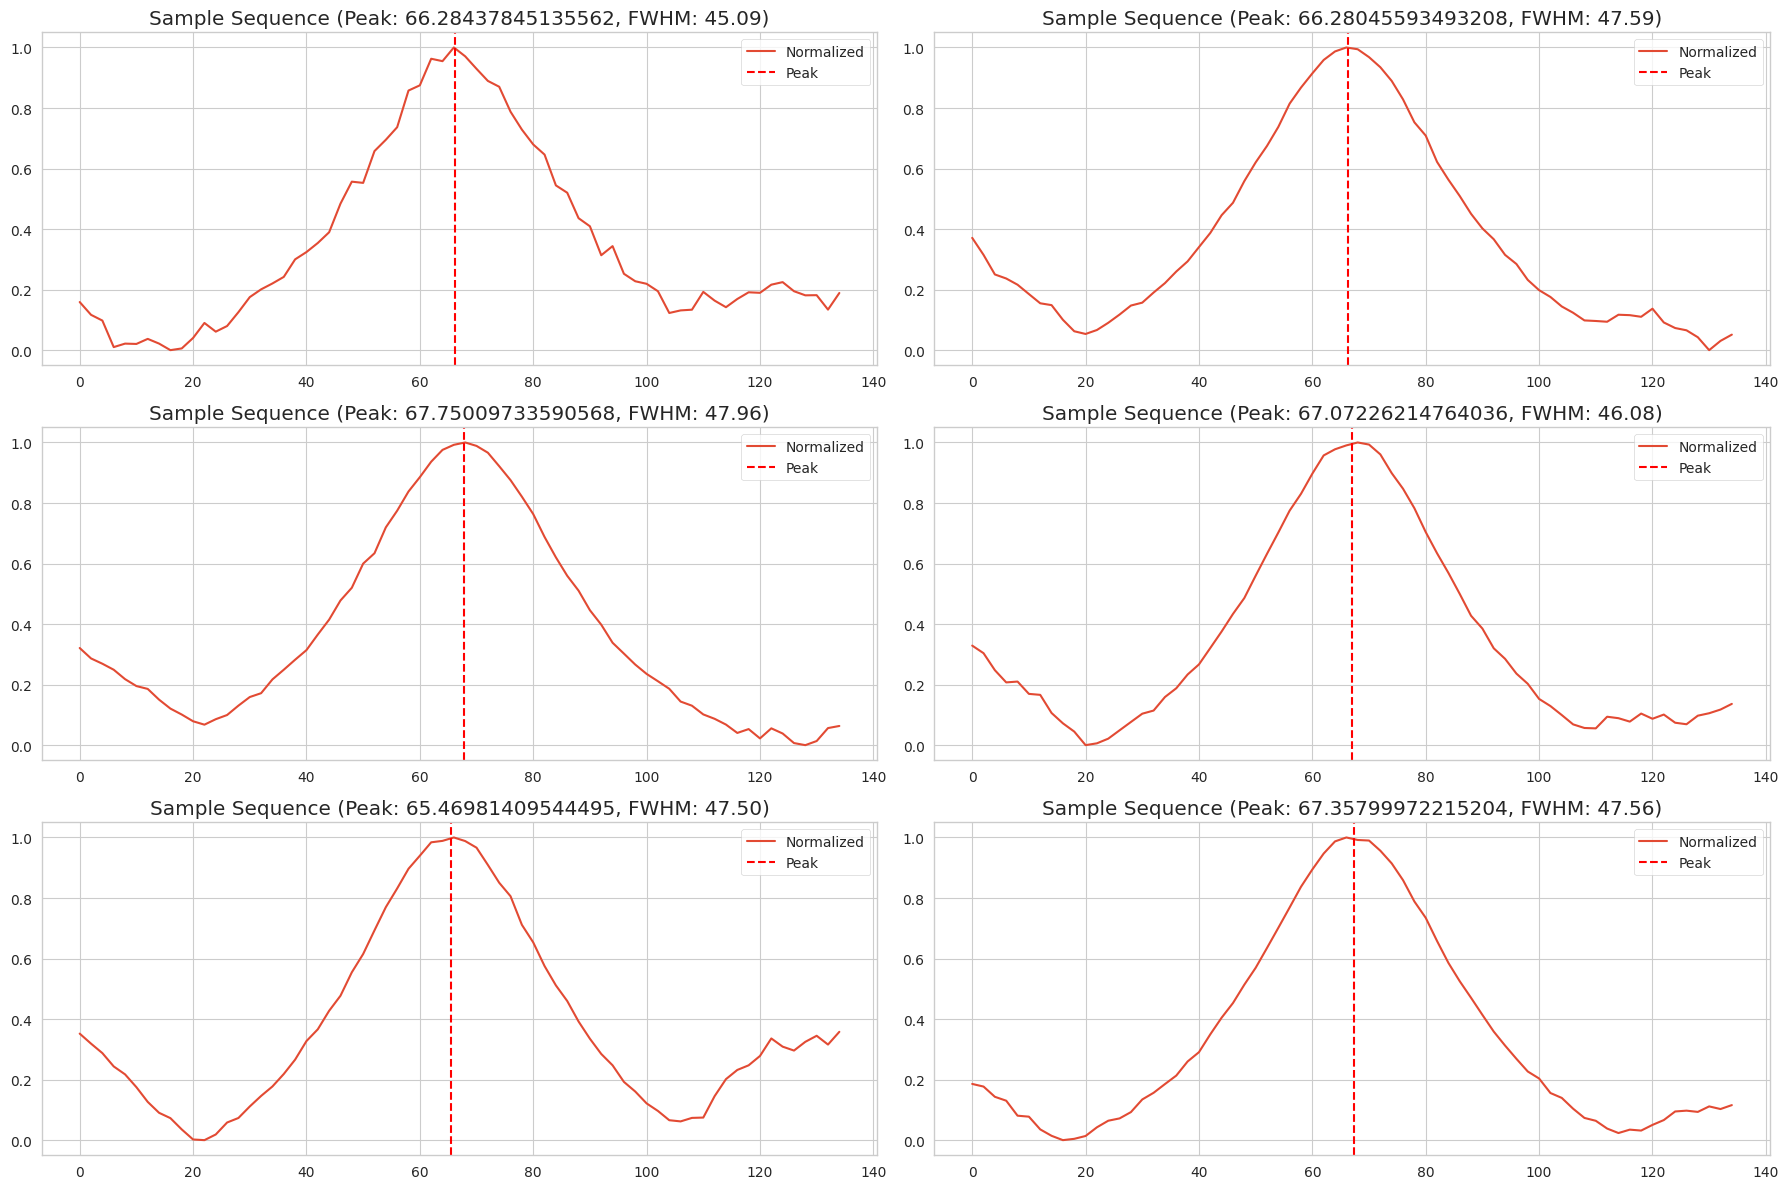

Preprocessing complete. Train shape: (240000, 68, 1)

Creating dual-output model architecture...
Creating dual-output CNN model...
Model architecture created successfully!


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 68, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 68, 128)   │      1,152 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 22, 128)   │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 22, 128)   │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 22, 128)   │    131,200 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 7, 128)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 7, 128)    │          0 │ max_pooling1d_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 896)       │          0 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 256)       │    229,632 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │     65,792 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_37[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 128)       │     32,896 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 128)       │     16,512 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 128)       │     16,512 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      8,256 │ dense_39[0][0]  

 Total params: 513,410 (1.96 MB)

 Trainable params: 511,874 (1.95 MB)

 Non-trainable params: 1,536 (6.00 KB)


Compiling model with dual-loss configuration...

Training model for 256 epochs...
Starting training for 256 epochs...
Epoch 1/256
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - fwhm_output_loss: 1.5401 - loss: 1.4258 - peak_output_loss: 1.1493
Epoch 1: val_loss improved from inf to 1.06177, saving model to /content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/models/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - fwhm_output_loss: 1.5371 - loss: 1.4224 - peak_output_loss: 1.1454 - val_fwhm_output_loss: 1.1155 - val_loss: 1.0618 - val_peak_output_loss: 0.8546 - learning_rate: 0.0010 - lr: 0.0010
Epoch 2/256
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - fwhm_output_loss: 0.7493 - loss: 0.5281 - peak_output_loss: 0.1544
Epoch 2: val_loss improved from 1.06177 to 0.91451, saving model to /content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/models/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - fwhm_output_loss: 0.7472 - loss: 0.5269 - peak_output_loss: 0.1541 - val_f

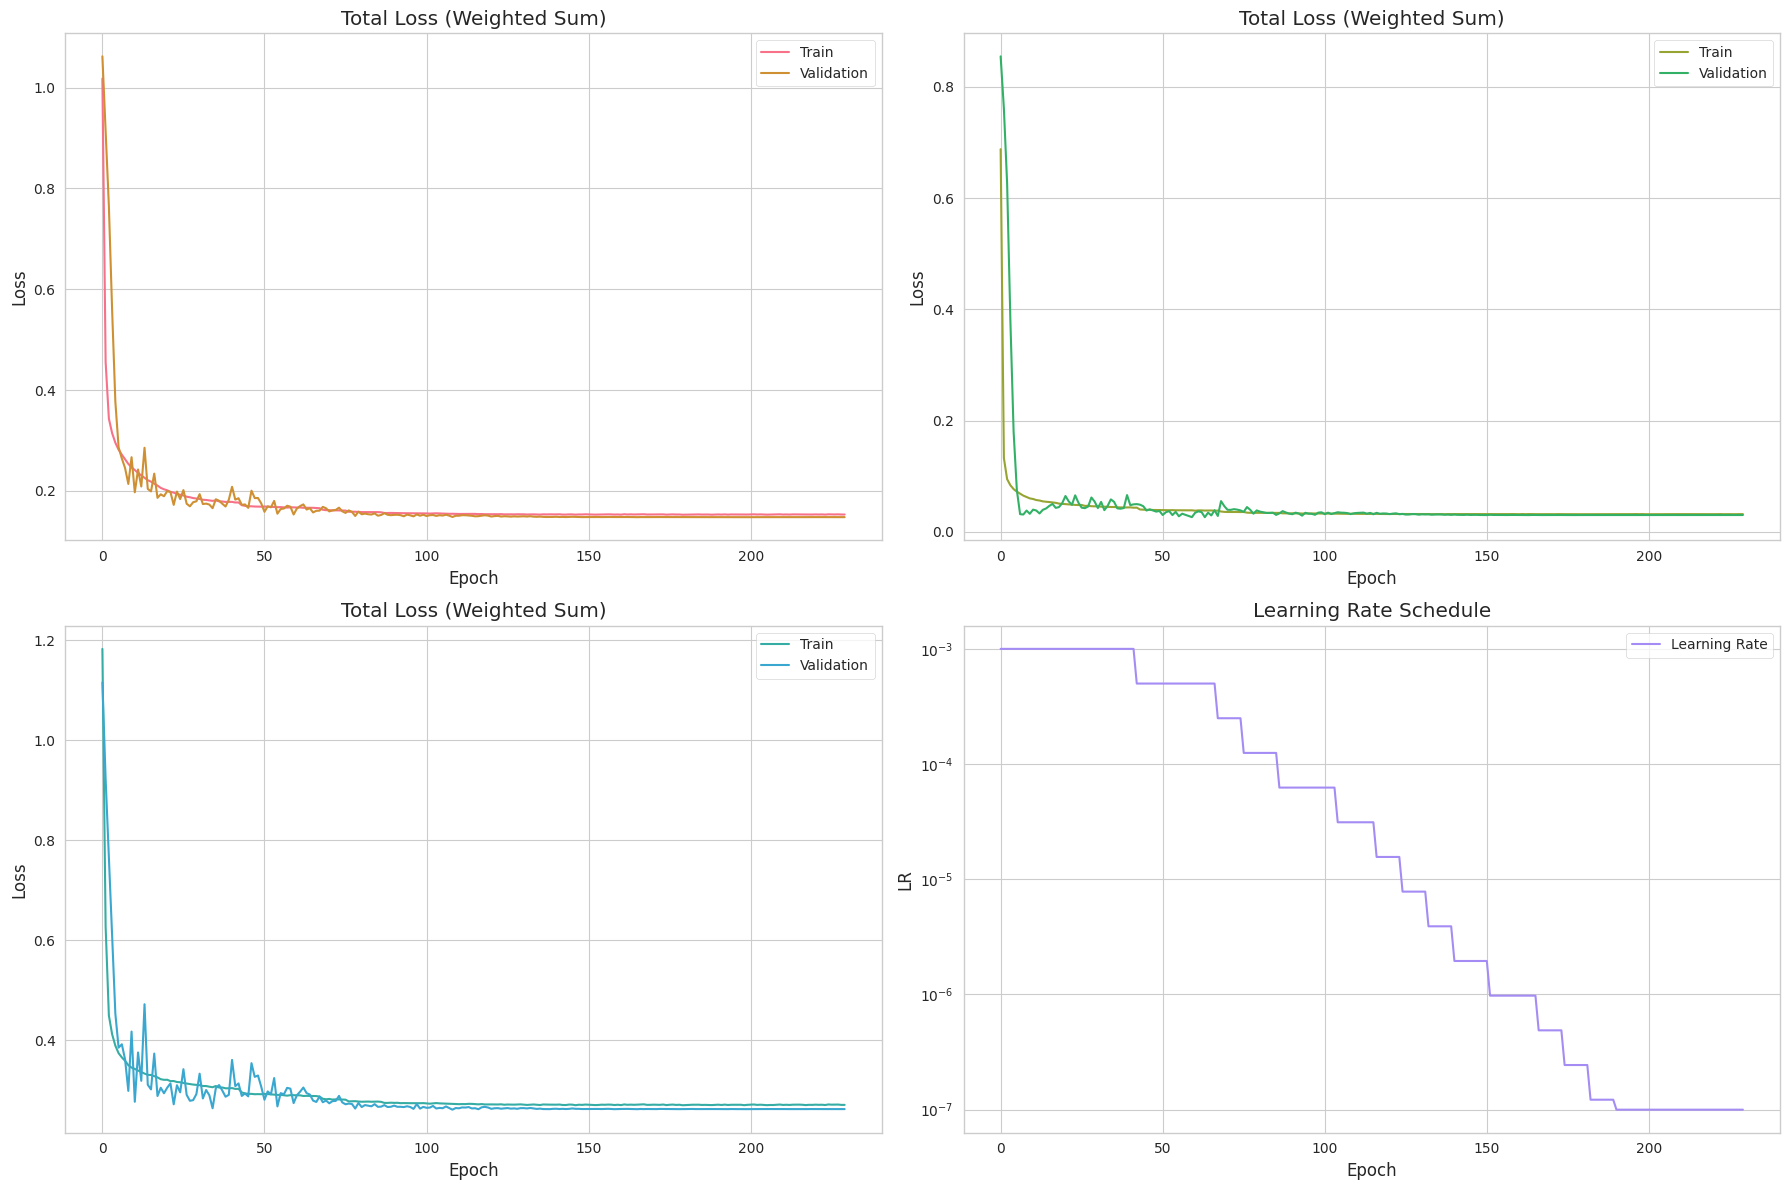

Training complete. Final val loss: 0.14804722368717194


In [ ]:
full_pipeline(real_bgs, MODEL_PATH, LOG_DIR_PATH, RESULTS_DIR_PATH, SCALERS_DIR_PATH, 300000, epochs=256, batch_size=2048)


Starting Model Evaluation
Loading BGS data from /content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/data/BGS_raw.txt...
Loaded data shape: (68, 4500)

Successfully loaded model from /content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/models/best_model.keras

Successfully loaded scalers from /content/drive/MyDrive/OstadSharif/ADVANCED_BGS_RGRS/models/scalers


analyzing Real Data sequences: 100%|██████████| 4500/4500 [00:00<00:00, 14462.56it/s]



Making predictions...
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


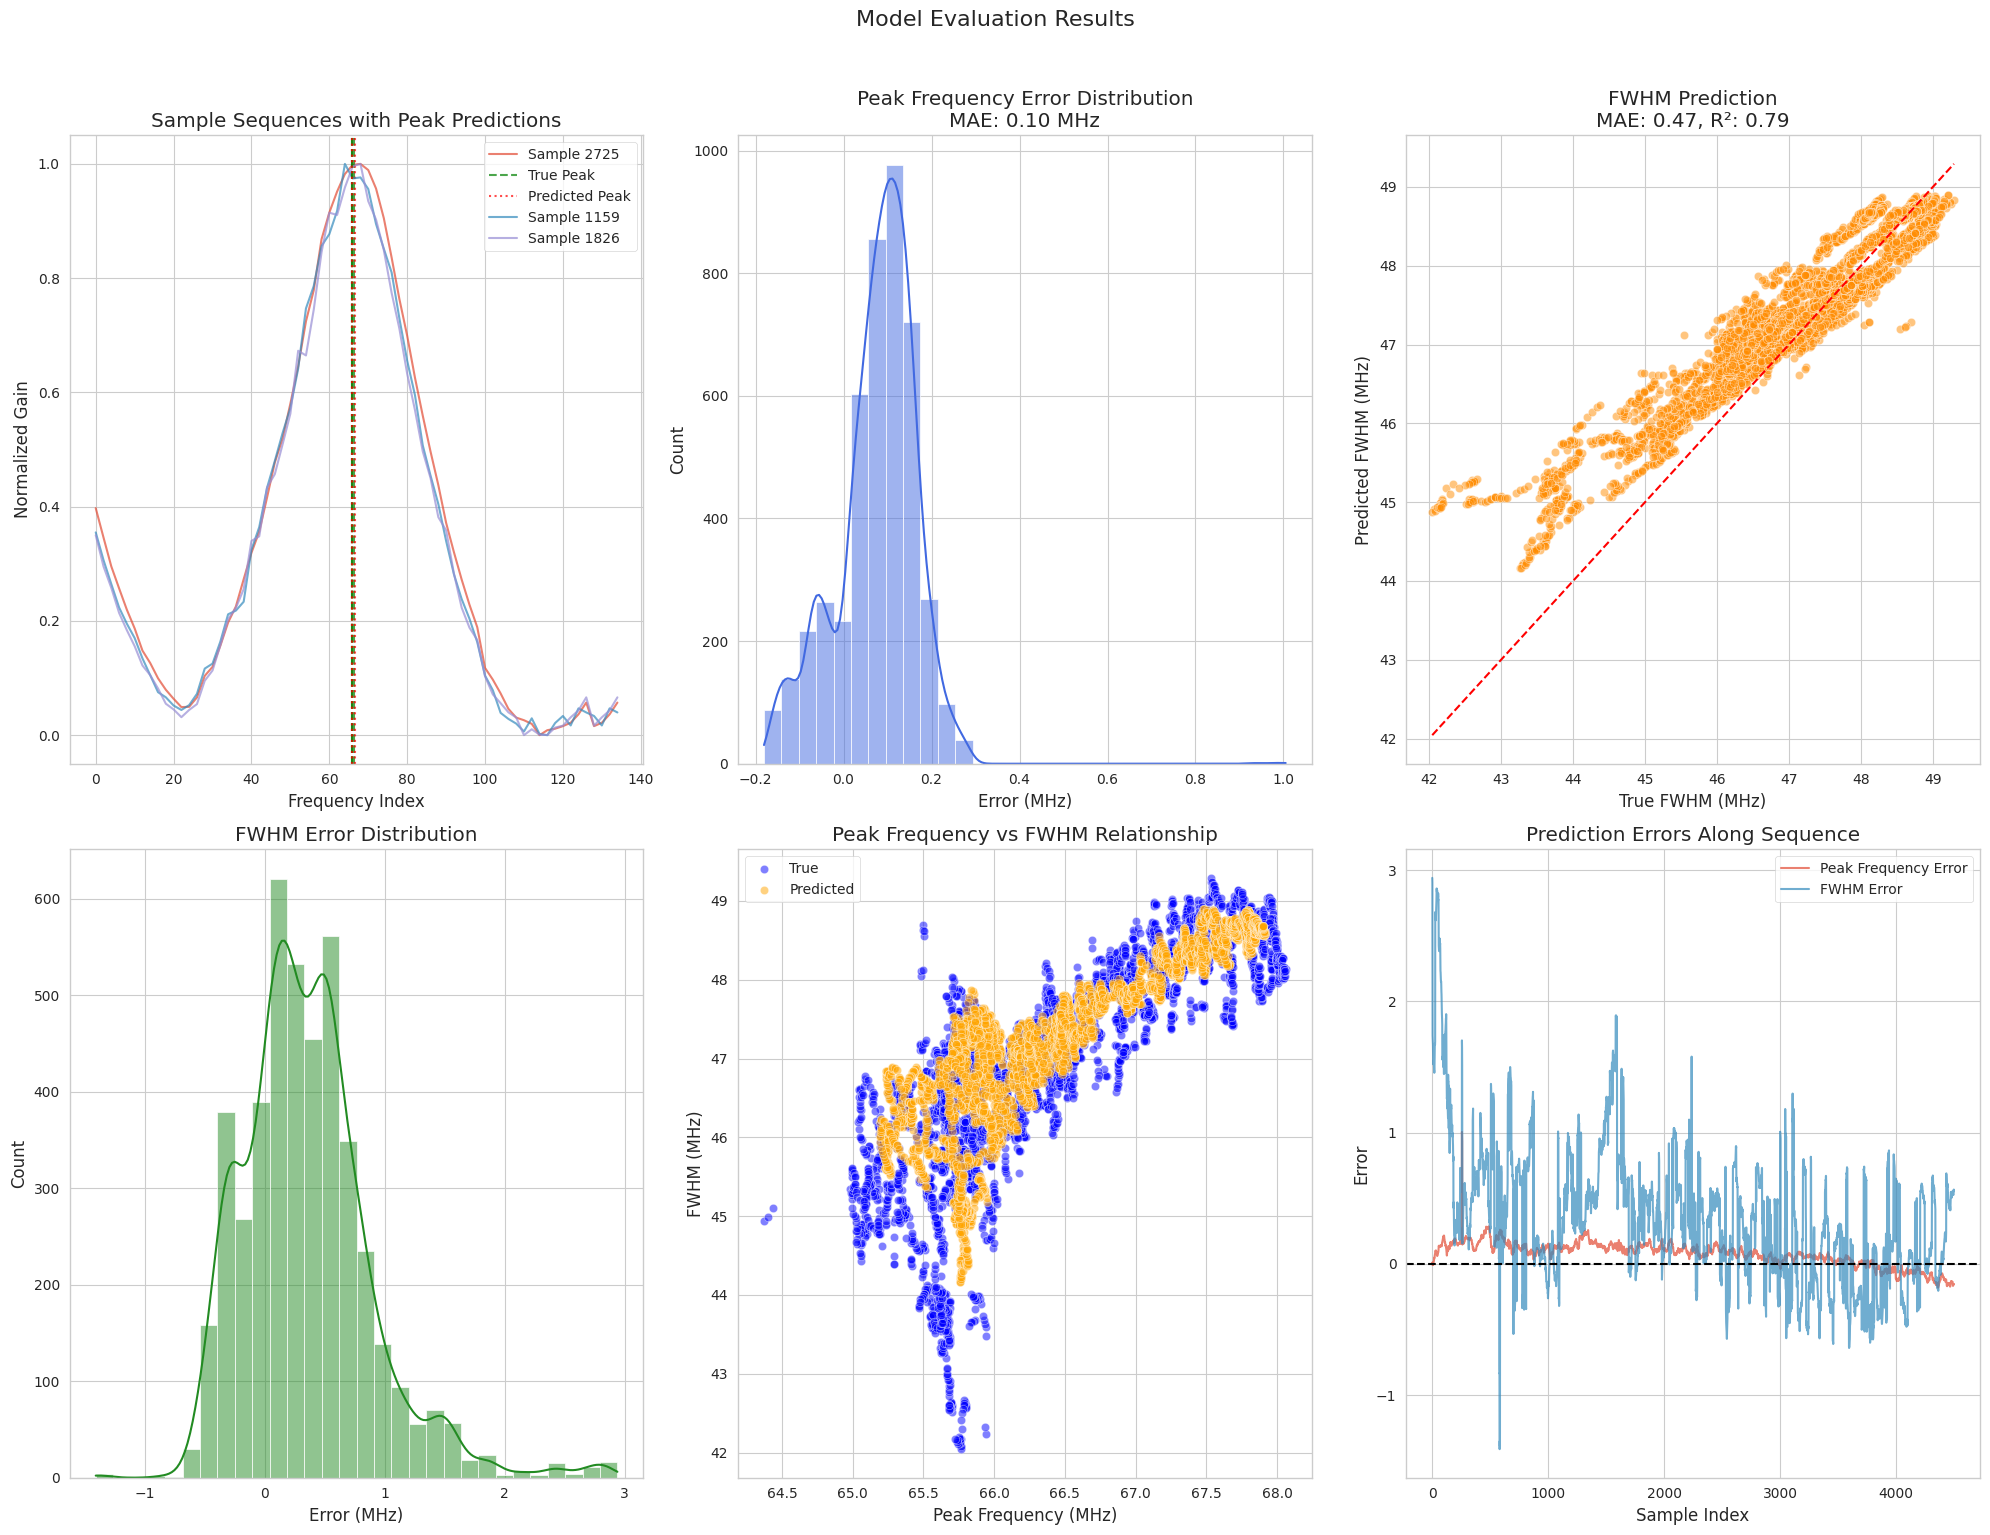


Model Evaluation Summary
Peak Frequency Metrics:
  MAE: 0.10 MHz
  RMSE: 0.12 MHz
  R²: 0.98

FWHM Metrics:
  MAE: 0.47 MHz
  RMSE: 0.64 MHz
  R²: 0.79


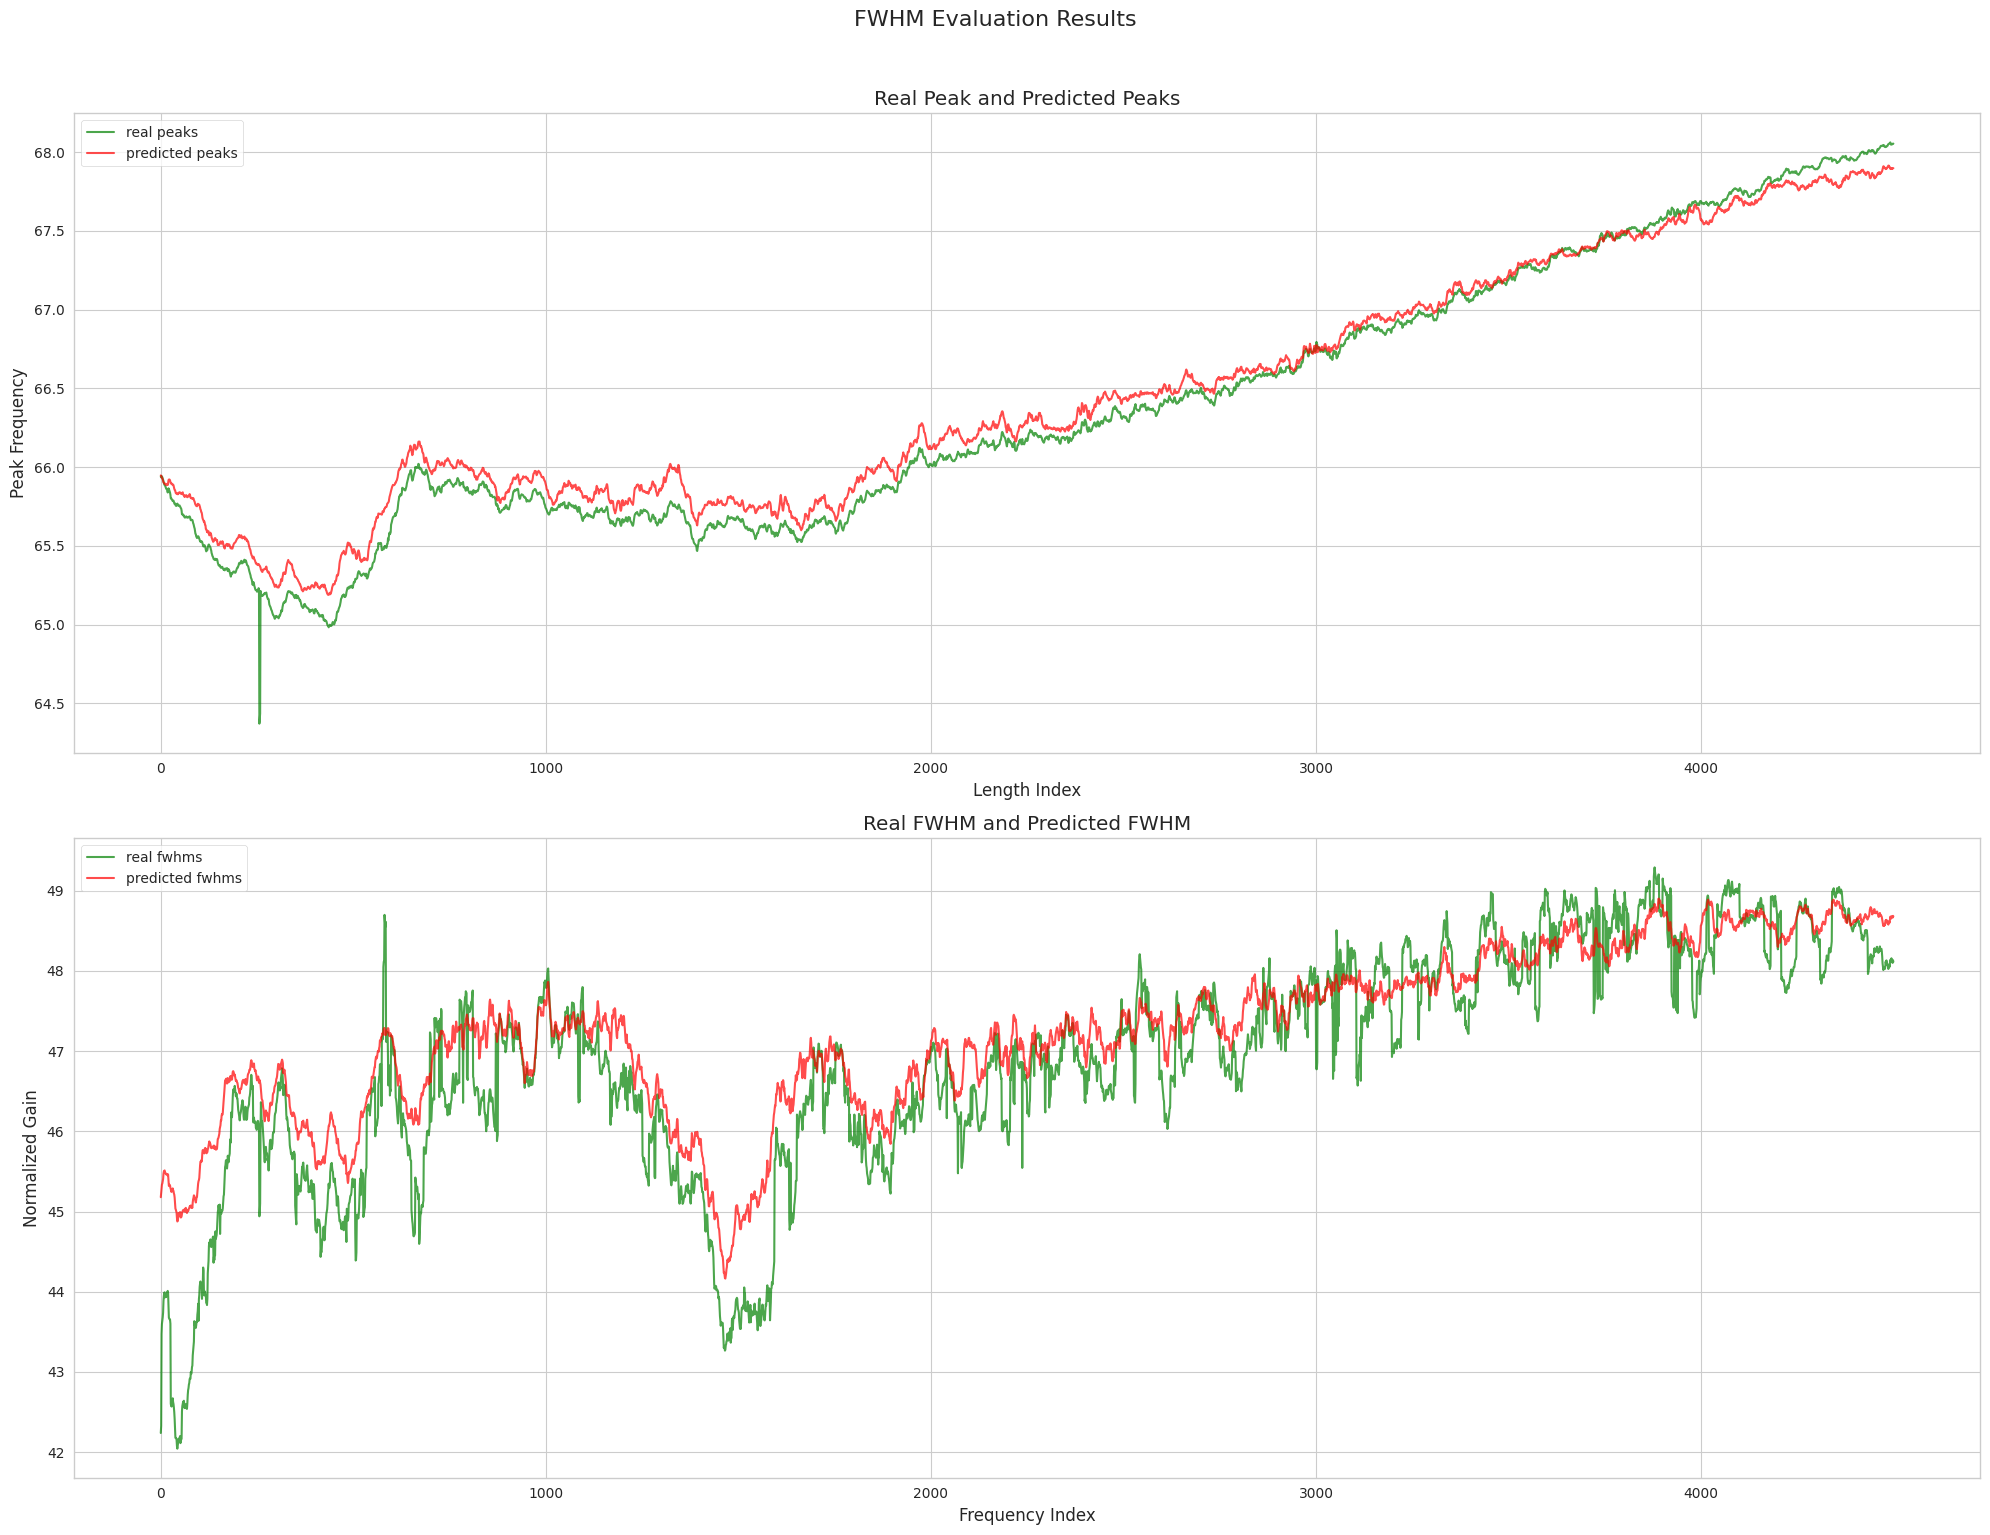

In [ ]:
eval_results = evaluate_prediction_model(MODEL_PATH, BGS_RAW_TXT_PATH, SCALERS_DIR_PATH)